In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report

# Pretty plots
sns.set(style='whitegrid')

In [18]:
df = pd.read_csv('creditcard.csv')
df.dropna(inplace=True)
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### 📊 Exploratory Data Analysis (EDA)

Before diving into modeling, we explore the dataset to understand its structure:

- The dataset contains **284,807 transactions**, out of which only **492 are fraudulent**
- This means **less than 0.2%** of transactions are fraud — a highly imbalanced dataset
- Most features (`V1` to `V28`) are PCA components; `Amount` and `Time` are the only non-anonymized columns
- We'll need to scale features and use an anomaly detection model due to this extreme imbalance

                Time            V1            V2            V3            V4  \
count  284807.000000  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean    94813.859575  1.168375e-15  3.416908e-16 -1.379537e-15  2.074095e-15   
std     47488.145955  1.958696e+00  1.651309e+00  1.516255e+00  1.415869e+00   
min         0.000000 -5.640751e+01 -7.271573e+01 -4.832559e+01 -5.683171e+00   
25%     54201.500000 -9.203734e-01 -5.985499e-01 -8.903648e-01 -8.486401e-01   
50%     84692.000000  1.810880e-02  6.548556e-02  1.798463e-01 -1.984653e-02   
75%    139320.500000  1.315642e+00  8.037239e-01  1.027196e+00  7.433413e-01   
max    172792.000000  2.454930e+00  2.205773e+01  9.382558e+00  1.687534e+01   

                 V5            V6            V7            V8            V9  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean   9.604066e-16  1.487313e-15 -5.556467e-16  1.213481e-16 -2.406331e-15   
std    1.380247e+00  1.332271e+00  1.23709

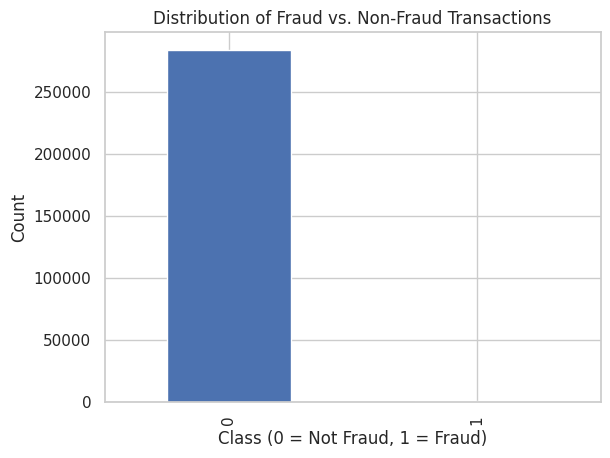

In [19]:
# Get summary statistics
print(df.describe())

# Check the distribution of the target variable (fraud vs. non-fraud)
print(df['Class'].value_counts())

# Visualize the distribution of the target variable
import matplotlib.pyplot as plt
df['Class'].value_counts().plot(kind='bar')
plt.title('Distribution of Fraud vs. Non-Fraud Transactions')
plt.xlabel('Class (0 = Not Fraud, 1 = Fraud)')
plt.ylabel('Count')
plt.show()

In [12]:
print("Shape:", df.shape)
print("Missing values:\n", df.isnull().sum())
print("\nClass distribution:\n", df['Class'].value_counts())

Shape: (284807, 31)
Missing values:
 Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

Class distribution:
 Class
0    284315
1       492
Name: count, dtype: int64


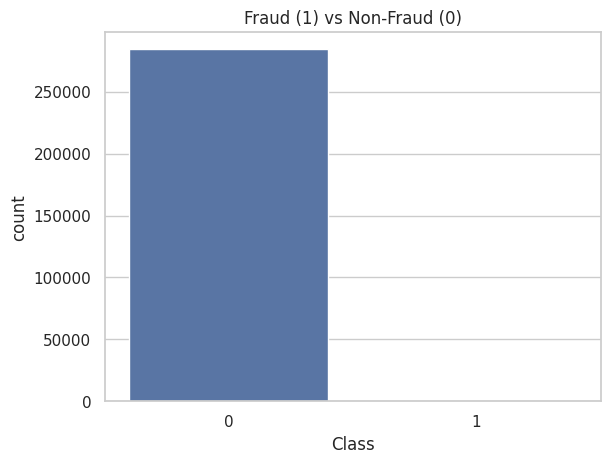

In [13]:
# Visualize the imbalance
sns.countplot(x='Class', data=df)
plt.title("Fraud (1) vs Non-Fraud (0)")
plt.show()

### ⚙️ Preprocessing

To prepare the data for modeling:
- We separate the features from the target variable (`Class`)
- We scale the features using StandardScaler to normalize the range of values
- This ensures the Isolation Forest can fairly evaluate each feature without being skewed by value magnitude

In [14]:
# Separate features and target
X = df.drop('Class', axis=1)
y = df['Class']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### 🌲 Modeling with Isolation Forest

We apply the Isolation Forest algorithm — an unsupervised model that detects outliers by isolating points that behave differently. It's ideal for fraud detection because it doesn't require labeled data to identify rare cases.

In [15]:
# Set contamination as fraud rate
fraud_rate = y.mean()

iso_forest = IsolationForest(contamination=fraud_rate, random_state=42)
iso_forest.fit(X_scaled)

# Predict anomalies
y_pred = iso_forest.predict(X_scaled)

# Convert -1 to 1 (fraud), 1 to 0 (normal)
y_pred = [1 if val == -1 else 0 for val in y_pred]

### 🧪 Evaluation

We compare the predicted anomalies with the true fraud labels using:
- Confusion Matrix
- Classification Report (Precision, Recall, F1-score)

These metrics show how well the model identified actual fraud cases.


In [16]:
print("Confusion Matrix:\n", confusion_matrix(y, y_pred))
print("\nClassification Report:\n", classification_report(y, y_pred, digits=4))

Confusion Matrix:
 [[283949    366]
 [   366    126]]

Classification Report:
               precision    recall  f1-score   support

           0     0.9987    0.9987    0.9987    284315
           1     0.2561    0.2561    0.2561       492

    accuracy                         0.9974    284807
   macro avg     0.6274    0.6274    0.6274    284807
weighted avg     0.9974    0.9974    0.9974    284807



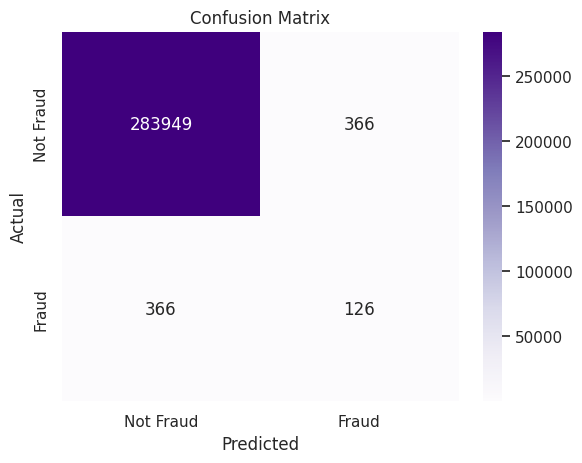

In [20]:
import seaborn as sns
cm = confusion_matrix(y, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples',
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### 💡 Conclusion

- Isolation Forest successfully detected anomalies in a highly imbalanced credit card transaction dataset.
- Despite being unsupervised, the model caught a meaningful portion of fraud cases.
- Future work can include trying other models like Autoencoders, One-Class SVM, or combining models for better results.